<a href="https://colab.research.google.com/github/codingpotato/pill-detection/blob/master/pill_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

## Clone Pill Detection

In [0]:
!git clone https://github.com/codingpotato/pill-detection.git

## Environment Variables

In [0]:
os.environ['ROOT_DIR'] = os.getcwd()
os.environ['IMAGE_DIR'] = os.path.join(os.environ['ROOT_DIR'], 'images')
os.environ['DATA_DIR'] = os.path.join(os.environ['ROOT_DIR'], 'data')
os.environ['TRAIN_DIR'] = os.path.join(os.environ['ROOT_DIR'], 'train')

os.environ['PILL_DETECTION_DIR'] = os.path.join(os.environ['ROOT_DIR'],
                                                'pill-detection')
os.environ['ORIGIN_IMAGE_DIR'] = os.path.join(os.environ['PILL_DETECTION_DIR'],
                                              'images')

In [0]:
!mkdir ${IMAGE_DIR}
!mkdir ${DATA_DIR}
!mkdir ${TRAIN_DIR}

## Download Pre-Trained Model

In [0]:
!wget http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz

In [0]:
!tar xfv ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz
!mv ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt* ${DATA_DIR}

## Install Tensorflow Object Detection API

In [0]:
!git clone https://github.com/tensorflow/models.git

In [0]:
!pip install Cython
!apt-get install protobuf-compiler
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools ${ROOT_DIR}/models/research/

In [0]:
%env PYTHONPATH=/content/models/research:/content/models/research/slim
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

## Test Tensorflow Object Detection API

In [0]:
!python object_detection/builders/model_builder_test.py

# Prepare Images

In [0]:
from PIL import Image
from random import randint
import matplotlib.pyplot as plt

image_width = 300
image_height = 300

def generate_images(name):
  for index in xrange(1, 101):
    image = Image.new('RGB', (image_width, image_height), '#000')
    image_path = os.path.join(os.environ['ORIGIN_IMAGE_DIR'], name + '.png')
    pill_image = Image.open(image_path)
    rotated_image = pill_image.rotate(randint(0, 359), expand=True)
    x = randint(0, image_width - rotated_image.size[0])
    y = randint(0, image_height - rotated_image.size[1])
    image.paste(rotated_image, (x, y))
    save_path = os.path.join(os.environ['IMAGE_DIR'], 
                             name + '_' + str(index) + '.png')
    image.save(save_path)

In [0]:
labels = ['325', '500']
for label in labels:
  generate_images(label)

In [0]:
import cv2

def boundingRect(image):
  image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  _, image_bw = cv2.threshold(image_bw, 1, 255, cv2.THRESH_BINARY)
  _, contours, _ = cv2.findContours(image_bw,
                                    cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  max_area = 0
  x, y, w, h = 0, 0, 0, 0
  for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > max_area:
      max_area = area
      x, y, w, h = cv2.boundingRect(cnt)
  return (x, y, w, h)

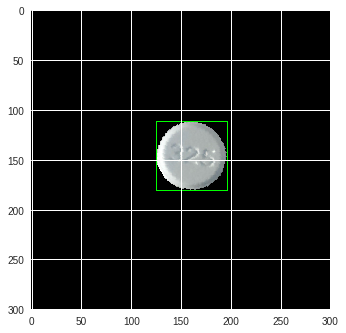

In [43]:
image_path = os.path.join(os.environ['IMAGE_DIR'], '325_31.png')
image = cv2.imread(image_path)
x, y, w, h = boundingRect(image)
cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
plt.imshow(image)

# Prepare Data

## Create Label Map

In [0]:
file_path = os.path.join(os.environ['DATA_DIR'], 'label_map.pbtxt')
with open(file_path, 'w') as f:
  for label in labels:
    f.write("item {\n  id: 1\n  name: '" + label + "'\n}\n\n")

## Generate TF Record

In [0]:
import tensorflow as tf
from object_detection.utils import dataset_util


def generate_tf_record(record_path, start, size):
  writer = tf.python_io.TFRecordWriter(record_path)
  label_index = 1
  for label in labels:
    for index in xrange(start, start + size):
      filename = os.path.join(os.environ['IMAGE_DIR'],
                              label + '_' + str(index) + '.png')
      image = cv2.imread(filename)
      x, y, w, h = boundingRect(image)
    
      image_format = b'png'
      with tf.gfile.GFile(filename, 'rb') as fid:
        encoded_png = fid.read()
      
      xmin = float(x) / image_width
      ymin = float(y) / image_height
      xmax = float(x + w - 1) / image_width
      ymax = float(y + h - 1) / image_height
      
      tf_example = tf.train.Example(features=tf.train.Features(feature={
          'image/height': dataset_util.int64_feature(image_width),
          'image/width': dataset_util.int64_feature(image_height),
          'image/filename': dataset_util.bytes_feature(filename),
          'image/source_id': dataset_util.bytes_feature(filename),
          'image/encoded': dataset_util.bytes_feature(encoded_png),
          'image/format': dataset_util.bytes_feature(image_format),
          'image/object/bbox/xmin': dataset_util.float_list_feature([xmin]),
          'image/object/bbox/xmax': dataset_util.float_list_feature([xmax]),
          'image/object/bbox/ymin': dataset_util.float_list_feature([ymin]),
          'image/object/bbox/ymax': dataset_util.float_list_feature([ymax]),
          'image/object/class/text': dataset_util.bytes_list_feature(
              [label]),
          'image/object/class/label': dataset_util.int64_list_feature(
              [label_index]),
      }))
      writer.write(tf_example.SerializeToString())
    label_index += 1
  writer.close()

In [0]:
train_record = os.path.join(os.environ['DATA_DIR'], 'train.record')
generate_tf_record(train_record, 1, 70)
test_record = os.path.join(os.environ['DATA_DIR'], 'test.record')
generate_tf_record(test_record, 71, 30)

## Create Config file

In [0]:
!cp object_detection/samples/configs/ssdlite_mobilenet_v2_coco.config ${DATA_DIR}
!sed -i "s|PATH_TO_BE_CONFIGURED|${DATA_DIR}|g" ${DATA_DIR}/ssdlite_mobilenet_v2_coco.config
!sed -i "s|mscoco_label_map.pbtxt|label_map.pbtxt|g" ${DATA_DIR}/ssdlite_mobilenet_v2_coco.config
!sed -i "s|mscoco_train.record-?????-of-00100|train.record|g" ${DATA_DIR}/ssdlite_mobilenet_v2_coco.config
!sed -i "s|mscoco_val.record-?????-of-00010|test.record|g" ${DATA_DIR}/ssdlite_mobilenet_v2_coco.config

# Train

In [0]:
get_ipython().system_raw('python object_detection/model_main.py \
    --pipeline_config_path=${DATA_DIR}/ssdlite_mobilenet_v2_coco.config \
    --model_dir=${TRAIN_DIR} \
    --num_train_steps=3000 \
    --sample_1_of_n_eval_examples=1 \
    --alsologtostderr &')

# TensorBoard

In [0]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

--2018-11-17 09:16:45--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.196.237.103, 34.196.224.14, 34.199.255.1, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.196.237.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  18.3MB/s    in 0.3s    

2018-11-17 09:16:46 (18.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
get_ipython().system_raw('tensorboard --logdir /content/pill-detection/ --host 0.0.0.0 --port 6006 &')

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
 "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://d2626ac6.ngrok.io


# Status

In [0]:
!ls -l /content/pill-detection/train
!cat /content/pill-detection/log/train.log

total 139964
-rw-r--r-- 1 root root       81 Nov 17 09:43 checkpoint
-rw-r--r-- 1 root root 38044978 Nov 17 09:43 events.out.tfevents.1542447787.0760019d5af2
-rw-r--r-- 1 root root 21940681 Nov 17 09:43 graph.pbtxt
-rw-r--r-- 1 root root 72211704 Nov 17 09:43 model.ckpt-0.data-00000-of-00001
-rw-r--r-- 1 root root    52065 Nov 17 09:43 model.ckpt-0.index
-rw-r--r-- 1 root root 11060634 Nov 17 09:43 model.ckpt-0.meta
/content/models/research/object_detection/utils/visualization_utils.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "object_detection/model_main.py", line 26, in <module>
    from object_detection import model_lib
  File "/content/models/research/object_detection/model_lib.py", line 27,

In [59]:
!uptime

 02:33:22 up  1:08,  0 users,  load average: 0.34, 0.15, 0.06


In [60]:
!ps -ef

UID          PID    PPID  C STIME TTY          TIME CMD
root           1       0  0 01:25 ?        00:00:00 /bin/bash -e /datalab/run.sh
root          10       1  0 01:25 ?        00:00:01 node /tools/node/bin/forever
root          31      10  0 01:25 ?        00:00:03 /tools/node/bin/node /datala
root          56      31  0 01:25 ?        00:00:05 /usr/bin/python2 /usr/local/
root          63      56  0 01:35 ?        00:00:10 /usr/bin/python -m ipykernel
root         357       1 98 02:33 ?        00:00:20 python2 object_detection/mod
root         398      63 99 02:33 ?        00:00:01 ps -ef


In [28]:
!pwd

/content/models/research


In [0]:
!cat ${DATA_DIR}/ssdlite_mobilenet_v2_coco.config

In [39]:
!ls /content/images

325_100.png  325_40.png  325_71.png   500_11.png  500_42.png  500_73.png
325_10.png   325_41.png  325_72.png   500_12.png  500_43.png  500_74.png
325_11.png   325_42.png  325_73.png   500_13.png  500_44.png  500_75.png
325_12.png   325_43.png  325_74.png   500_14.png  500_45.png  500_76.png
325_13.png   325_44.png  325_75.png   500_15.png  500_46.png  500_77.png
325_14.png   325_45.png  325_76.png   500_16.png  500_47.png  500_78.png
325_15.png   325_46.png  325_77.png   500_17.png  500_48.png  500_79.png
325_16.png   325_47.png  325_78.png   500_18.png  500_49.png  500_7.png
325_17.png   325_48.png  325_79.png   500_19.png  500_4.png   500_80.png
325_18.png   325_49.png  325_7.png    500_1.png   500_50.png  500_81.png
325_19.png   325_4.png	 325_80.png   500_20.png  500_51.png  500_82.png
325_1.png    325_50.png  325_81.png   500_21.png  500_52.png  500_83.png
325_20.png   325_51.png  325_82.png   500_22.png  500_53.png  500_84.png
325_21.png   325_52.png  325_83.png   500_23.png  500

In [50]:
%cat /content/data/label_map.pbtxt

item {
  id: 1
  name: '325'
}

item {
  id: 1
  name: '500'
}

